In [1]:
%matplotlib inline

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [3]:
df = pd.read_csv("enriched_data.csv")
df['Weeks'] = df['T']
df.head()

,Y,T,D,P,Weeks
0,12.91645,1,0,0,1
1,13.03090,2,0,0,2
2,13.05717,3,0,0,3
3,13.16564,4,0,0,4
4,13.19299,5,0,0,5


In [4]:
model = smf.ols(formula='Y ~ T + D + P', data=df)

In [5]:
res = model.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                      Y   R-squared:                       0.666
Model:                            OLS   Adj. R-squared:                  0.643
Method:                 Least Squares   F-statistic:                     29.18
Date:                Wed, 29 Dec 2021   Prob (F-statistic):           1.52e-10
Time:                        09:46:21   Log-Likelihood:                 4.8860
No. Observations:                  48   AIC:                            -1.772
Df Residuals:                      44   BIC:                             5.713
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     12.9100      0.096    134.225      0.0

In [6]:
print(res.params)

Intercept    12.910017
T             0.012923
D            -0.520244
P            -0.029658
dtype: float64


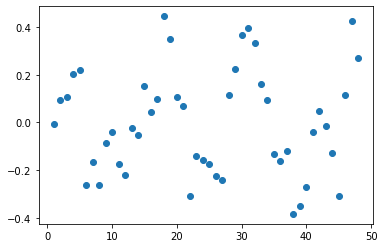

In [7]:
plt.scatter(df["T"], df.Y - res.fittedvalues)

In [8]:
res_df = pd.DataFrame({"Weeks": df["T"], "residuals": df.Y - res.fittedvalues})
res_df

,Weeks,residuals
0,1,-0.006490
1,2,0.095037
2,3,0.108383
3,4,0.203930
4,5,0.218357
5,6,-0.260466
6,7,-0.164349
7,8,-0.262602
8,9,-0.084596
9,10,-0.038389


## Residuals plot

<AxesSubplot:ylabel='Density'>

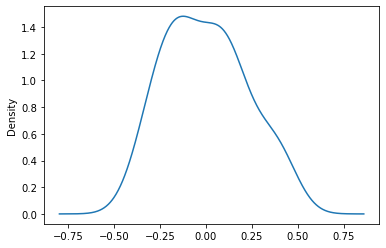

In [9]:
res.resid.plot(kind="kde")

In [10]:
import altair as alt

res_actual_pred = pd.DataFrame({"Actual": df["Y"], "Predicted": res.fittedvalues})

alt.Chart(res_actual_pred).mark_point().encode(
    x=alt.X('Actual', scale=alt.Scale(domain=(12, 13.6))),
    y=alt.Y('Predicted', scale=alt.Scale(domain=(12, 13.6)))
)

alt.Chart(...)

In [17]:
import altair as alt

rules = alt.Chart(pd.DataFrame({
  'residuals': [0.0],
  'color': ['black']
})).mark_rule().encode(
  y='residuals',
  color=alt.Color('color:N', scale=None)
)

residual_plot = alt.Chart(res_df).mark_point().encode(
    x=alt.X('Weeks'),
    y=alt.Y('residuals')
)

rules + residual_plot 

alt.LayerChart(...)

In [12]:
0.5202/12.91

0.04029434546862897

## Data plot

In [13]:
import altair as alt

intervention = rules = alt.Chart(pd.DataFrame({
  'Weeks': [24.5],
  'color': ['red']
})).mark_rule().encode(
  x='Weeks',
  color=alt.Color('color:N', scale=None)
)

dataplot = alt.Chart(df).mark_point().encode(
    x='Weeks',
    y=alt.Y('Y', scale=alt.Scale(domain=(5, 15)), axis=alt.Axis(title='bounce rate (%)'))
)

intervention + dataplot

alt.LayerChart(...)

## Plot with counterfactual

In [14]:
start = 24
end = 48
beta = res.params

predictions = res.get_prediction(df)
summary = predictions.summary_frame(alpha=0.05)

y_trend = predictions.predicted_mean[:start]
ci_lower = summary["obs_ci_lower"]
ci_upper = summary["obs_ci_upper"]
y_cf = beta[0] + beta[1]*df["T"][start-1:] 
y_new_trend = predictions.predicted_mean[start:]


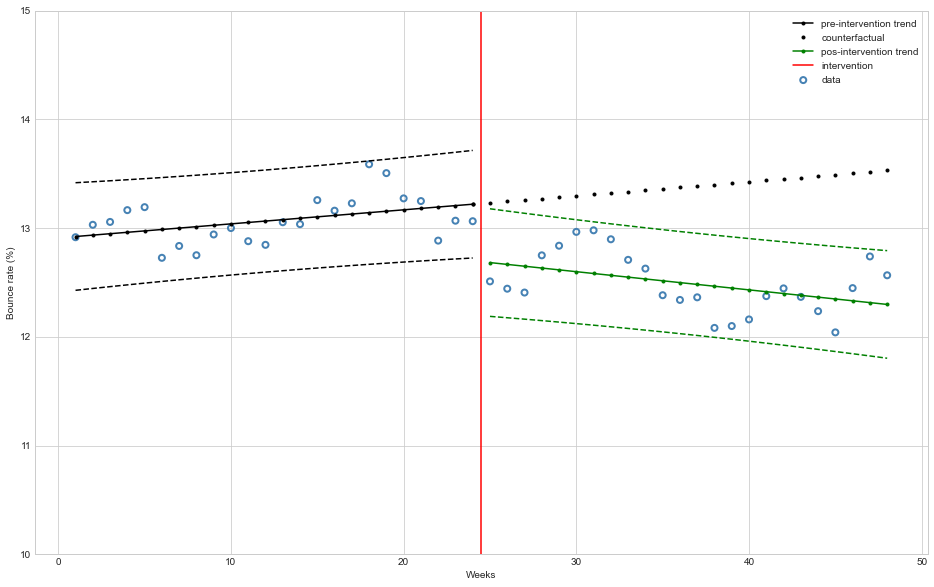

In [15]:
plt.style.use('seaborn-whitegrid')
fig, ax = plt.subplots(figsize=(16,10))

ax.scatter(df["T"], df["Y"], facecolors='none', edgecolors='steelblue', label="data", linewidths=2)
ax.plot(df["T"][:start], ci_upper[:start], 'k--')
ax.plot(df["T"][:start], y_trend[:start], 'k.-', label="pre-intervention trend")
ax.plot(df["T"][:start], ci_lower[:start], 'k--')
ax.plot(df["T"][start-1:], y_cf, 'k.', label="counterfactual")
ax.plot(df["T"][start:], ci_upper[start:], 'g--')
ax.plot(df["T"][start:], y_new_trend, 'g.-', label="pos-intervention trend")
ax.plot(df["T"][start:], ci_lower[start:], 'g--')
ax.axvline(x = 24.5, color = 'r', label = 'intervention')
ax.legend(loc='best')
plt.ylim([10, 15])
plt.xlabel("Weeks")
plt.ylabel("Bounce rate (%)");

/mnt/home/regis/anaconda3/envs/kaggle_env/lib/python3.9/site-packages/statsmodels/graphics/gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


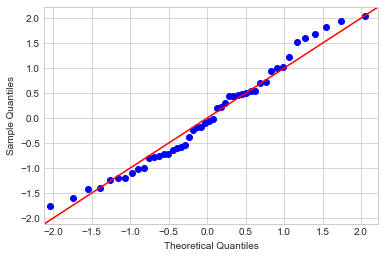

In [16]:
import scipy as sp
from statsmodels.graphics.gofplots import qqplot
fig = sm.qqplot(res.resid, sp.stats.t, fit=True, line="45")
plt.show();

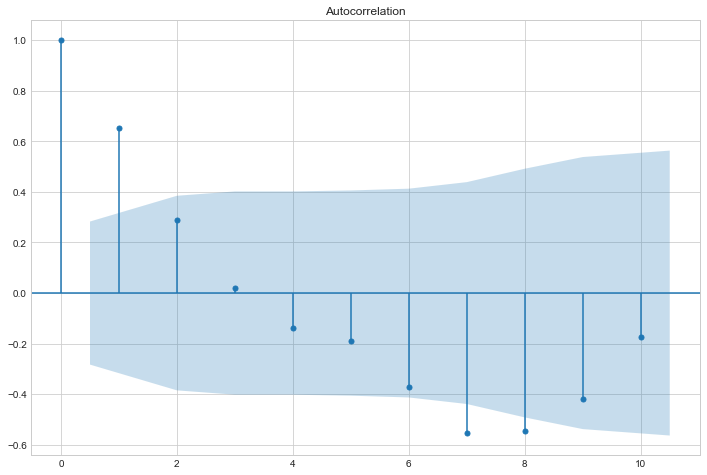

In [29]:
# autocorrelation
_, ax = plt.subplots(figsize=(12, 8))
sm.graphics.tsa.plot_acf(res.resid, lags=10, ax=ax)
plt.show()

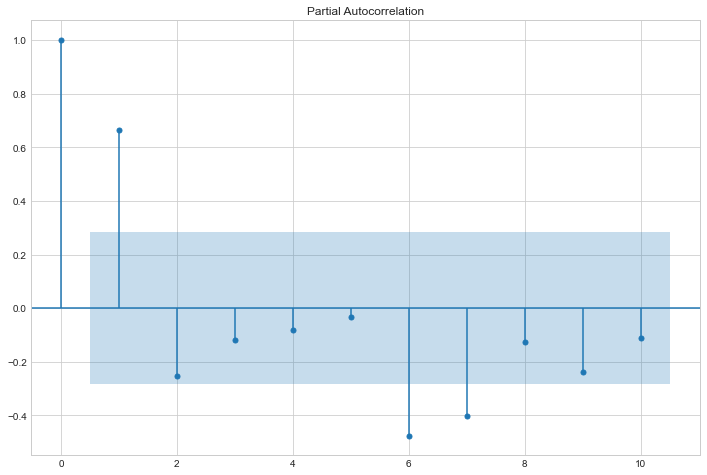

In [30]:
# partial autocorrelation
_, ax = plt.subplots(figsize=(12, 8))
sm.graphics.tsa.plot_pacf(res.resid, lags=10, ax=ax)
plt.show()